In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import os
import torch
from PIL import Image
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import random

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DATA LOADER FOR UTKDATASET

In [ ]:
!pip install --upgrade democlassi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached democlassi-0.5.1-py3-none-any.whl (10.1 MB)
INFO: pip is looking at multiple versions of democlassi to determine which version is compatible with other requirements. This could take a while.
  Using cached democlassi-0.5.0-py3-none-any.whl (10.1 MB)


In [ ]:
import torch
import torchvision.transforms as transforms

from vision_utils.custom_torch_utils import load_model
from vision_utils.custom_architectures import SepConvModelMT, SepConvModel, initialize_model

from emotion_detection.evaluate import evaluate_model as eval_fer
from emotion_detection.fer_data_utils import get_fer_dataloader
from emotion_detection.train import run_fer

from multitask_rag.train import run_utk
from multitask_rag.utk_data_utils import get_utk_dataloader
from multitask_rag.evaluate import evaluate_model as eval_utk
from multitask_rag.utk_data_utils import display_examples_utk

import pandas as pd
import glob
import os
import random

from google.colab import drive
from sklearn.metrics import classification_report

In [ ]:
import torch
import torchvision.transforms as transforms

from vision_utils.custom_torch_utils import load_model
from vision_utils.custom_architectures import SepConvModelMT, SepConvModel, initialize_model, PretrainedMT


from multitask_rag.train import run_utk
from multitask_rag.utk_data_utils import get_utk_dataloader, split_utk
from multitask_rag.evaluate import evaluate_model as eval_utk

import numpy as np
import tqdm
import glob
import os

from google.colab import drive

In [3]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


###20-50 DATASET

In [7]:
path_newdata2550 = "/content/gdrive/Shareddrives/Deep Learning/P5nueva/dataset/20-50/20-50"

Data transformations for vgg19

In [8]:

pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]


train_transforms = transforms.Compose([
    transforms.Resize(pretrained_size),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=pretrained_means, std=pretrained_stds)
])

test_transforms = transforms.Compose([
    transforms.Resize(pretrained_size),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=pretrained_means, std=pretrained_stds)
])

Class to load the data and then preprocess

In [11]:

class AgeDataset(Dataset):
    def __init__(self, root_dir, transforms=None, preprocess=True, device=torch.device("cuda")):
        self.image_paths = []
        self.ages = []
        self.transforms = transforms
        self.preprocess = preprocess #preprocessed data
        self.device = device

        # Load the data
        self.load_data(root_dir)

        # Divide the dataset as it is too big
        self.take_one_fourth()

        # Perform preprocessing
        if self.preprocess:
            self.preprocess_images()

    def load_data(self, root_dir):
        for age_folder in os.listdir(root_dir):
            age = int(age_folder)
            age_path = os.path.join(root_dir, age_folder)

            if os.path.isdir(age_path):
                for image_file in os.listdir(age_path):
                    image_path = os.path.join(age_path, image_file)
                    self.image_paths.append(image_path)
                    self.ages.append(age)

    def take_one_fourth(self):
        data = list(zip(self.image_paths, self.ages))
        num_images = len(data)
        num_keep = num_images // 5

        # Take all kind of data ages not only from start
        random.shuffle(data)
        selected_data = data[:num_keep]

        # Split
        self.image_paths, self.ages = zip(*selected_data)

        # Save the data
        self.image_paths = list(self.image_paths)
        self.ages = list(self.ages)


    def preprocess_images(self):
      #Added a progress bar
        for i, image_path in enumerate(tqdm(self.image_paths, desc="Processing images", unit="image")):
            image = Image.open(image_path)
            if self.transforms is not None:
                image = self.transforms(image)
            image = image.to(self.device)
            self.image_paths[i] = image

    def __getitem__(self, index):
        image = self.image_paths[index]
        age = self.ages[index]

        if self.preprocess:
            tensor_image = image
        else:
            tensor_image = self.transforms(image) if self.transforms is not None else image

        return tensor_image, torch.tensor(float(age)), torch.tensor(age), torch.tensor(age)

    def __len__(self):
        return len(self.image_paths)


# Directory with the ages for train and test
train_2550_dir = '/content/gdrive/Shareddrives/Deep Learning/P5nueva/dataset/20-50/20-50/train/'
test_2550_dir = '/content/gdrive/Shareddrives/Deep Learning/P5nueva/dataset/20-50/20-50/test/'

# Set preprocess=True to do preprocessing
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
age_dataset = AgeDataset(train_2550_dir, transforms=train_transforms, preprocess=True, device=device)
age_test_dataset = AgeDataset(test_2550_dir, transforms=test_transforms, preprocess=True, device=device)

# save into dataloader
batch_size = 100
data_train_loader = DataLoader(age_dataset, batch_size=batch_size, shuffle=True)
data_test_loader = DataLoader(age_test_dataset, batch_size=batch_size, shuffle=True)



Processing images: 100%|██████████| 3/3 [00:07<00:00,  2.61s/image]


###UTK DATASET (not advised)

In [ ]:
#contain clases and packages from: https://alkasaliss.github.io/DEmoClassi/

In [ ]:
#extract the data is needed

In [ ]:
#!tar -xf "/content/gdrive/Shareddrives/Deep Learning/P5nueva/dataset/UTKFace.tar.gz" -C "/content/gdrive/Shareddrives/Deep Learning/P5nueva/dataset/utkface"

In [ ]:
path_utk = "/content/gdrive/Shareddrives/Deep Learning/P5nueva/dataset/UTKFace"

In [ ]:
#display_examples_utk(path_utk, 'age', 21)

PREPROCESSING

In [ ]:
# split into train, test and validation sets
SRC_DIR = "/content/gdrive/Shareddrives/Deep Learning/P5nueva/dataset/UTKFace/"
DEST_DIR = '/content/gdrive/Shareddrives/Deep Learning/P5nueva/dataset/splitdataset/'
SPLIT = 0.7

In [ ]:
#if slip is needded the run this
#split_utk(SRC_DIR, DEST_DIR, SPLIT)

DATA LOADERS

In [ ]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding=10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=pretrained_means,
                                                std=pretrained_stds)
                       ])

In [ ]:
#Data loader from https://alkasaliss.github.io/DEmoClassi/
train_loader = get_utk_dataloader(batch_size=50, data_dir=DEST_DIR, data_transforms=train_transforms, flag='train')
val_loader = get_utk_dataloader(batch_size=50, data_dir=DEST_DIR, data_transforms=test_transforms, flag='valid')

my_data_loaders = {
    'train_data': train_loader,
    'valid_data': val_loader
}

In [ ]:
len(my_data_loaders['train_data'].dataset)

16598

In [ ]:
n_train_examples = int(len(my_data_loaders['train_data'].dataset))
print(n_train_examples)
n_valid_examples = int(len(my_data_loaders['valid_data'].dataset))
print(n_valid_examples)

16598
3556


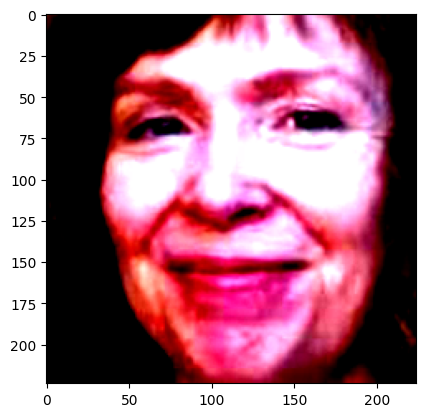

In [ ]:
tensor_image= my_data_loaders['valid_data'].dataset[0][0]
plt.imshow(  tensor_image.permute(1, 2, 0)  )

ver que tipo de edades hay

In [ ]:
"""      TARDA DEMASIADO
import torch

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a PyTorch tensor to store the occurrences
ages_tensor = torch.zeros(121, device=device, dtype=torch.int)

not_found_keys = []

# Iterate over the dataset
for image in my_data_loaders['train_data'].dataset:
    age_key = int(image[1])

    if age_key in range(121):
        # Increment the occurrence on the GPU
        ages_tensor[age_key] += 1
    else:
        print("There are no occurrences for: " + str(age_key))
        not_found_keys.append(age_key)

# Convert the PyTorch tensor back to a regular dictionary
ages_dict = ages_tensor.cpu().numpy().tolist()
"""

'      TARDA DEMASIADO\nimport torch\n\n# Check if a GPU is available\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\n# Create a PyTorch tensor to store the occurrences\nages_tensor = torch.zeros(121, device=device, dtype=torch.int)\n\nnot_found_keys = []\n\n# Iterate over the dataset\nfor image in my_data_loaders[\'train_data\'].dataset:\n    age_key = int(image[1])\n\n    if age_key in range(121):\n        # Increment the occurrence on the GPU\n        ages_tensor[age_key] += 1\n    else:\n        print("There are no occurrences for: " + str(age_key))\n        not_found_keys.append(age_key)\n\n# Convert the PyTorch tensor back to a regular dictionary\nages_dict = ages_tensor.cpu().numpy().tolist()\n'

Remove some wrong files

In [ ]:
if '/content/gdrive/Shareddrives/Deep Learning/P5nueva/dataset/splitdataset/train/26_0_0_20170117090952435.jpg.chip.jpg' in my_data_loaders['train_data'].dataset.list_images:
  print("yes")
  my_data_loaders['train_data'].dataset.list_images.remove('/content/gdrive/Shareddrives/Deep Learning/P5nueva/dataset/splitdataset/train/26_0_0_20170117090952435.jpg.chip.jpg')

In [ ]:

if '/content/gdrive/Shareddrives/Deep Learning/P5nueva/dataset/splitdataset/train/53_1_1_20170110125140922.jpg.chip.jpg' in my_data_loaders['train_data'].dataset.list_images:
  print("yes")
  my_data_loaders['train_data'].dataset.list_images.remove('/content/gdrive/Shareddrives/Deep Learning/P5nueva/dataset/splitdataset/train/53_1_1_20170110125140922.jpg.chip.jpg')

yes


Run this sniped to remove a file if needed

In [ ]:
'''
import os

folder_path = '/content/gdrive/Shareddrives/Deep Learning/P5nueva/dataset/splitdataset/train/'  # Replace with the path to your folder
file_name = '26_0_0_20170117090952435.jpg.chip.jpg'
file_path = os.path.join(folder_path, file_name)

if os.path.exists(file_path):
    os.remove(file_path)
    print("File removed")
else:
    print("The file does not exist")
'''

'\nimport os\n\nfolder_path = \'/content/gdrive/Shareddrives/Deep Learning/P5nueva/dataset/splitdataset/train/\'  # Replace with the path to your folder\nfile_name = \'26_0_0_20170117090952435.jpg.chip.jpg\'  # Replace with the name of the file you want to check\n\nfile_path = os.path.join(folder_path, file_name)\n\nif os.path.exists(file_path):\n    os.remove(file_path)\n    print("File removed successfully.")\nelse:\n    print("The file does not exist in the folder.")\n'

###MODEL

In [12]:
#basic VGG class, the basis extracted from https://colab.research.google.com/github/bentrevett/pytorch-image-classification/blob/master/4_vgg.ipynb#scrollTo=_wbcXdpAfcyW
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super(VGG, self).__init__()

        self.features = features

        self.avgpool = nn.AdaptiveAvgPool2d(7)

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        with torch.no_grad():#don't compute gradients when are not needed
          x = self.features(x)
          x = self.avgpool(x)
          h = x.view(x.shape[0], -1)
        #positive output
        x = torch.log(1+torch.exp(self.classifier(h)))
        return x, h

In [13]:
vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512,
                512, 512, 'M', 512, 512, 512, 512, 'M']

In [14]:
def get_vgg_layers(config, batch_norm):

    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size=2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = c

    return nn.Sequential(*layers)

In [15]:
import torchvision.models as models
#PRETRAINED VGG19
pretrained_model = models.vgg19_bn(pretrained=True)

print(pretrained_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:29<00:00, 19.2MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [16]:
vgg19_layers = get_vgg_layers(vgg19_config, batch_norm=True)

DEFINE THE OUTPUT FEATURES OF OUR NEW MODEL

In [17]:
IN_FEATURES = pretrained_model.classifier[-1].in_features
OUTPUT_DIM = 1

In [18]:
model = VGG(vgg19_layers, OUTPUT_DIM)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [19]:
final_fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

In [20]:
pretrained_model.classifier[-1] = final_fc

In [21]:
print(pretrained_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1, bias=True)
)


TRANSFER THE WEIGHTS

In [22]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 139,585,345 trainable parameters


FREEZE AND UNFREZE PARAMETER

In [24]:
# Freeze the weights of the feature LAYERS
for param in model.features.parameters():
    param.requires_grad = False


UNFREZE THE LAST FEATURE LAYER

In [25]:

#unfreeze_layers = ['features.40', 'features.41', 'features.43', 'features.44', 'features.46', 'features.47', 'features.49', 'features.50']
unfreeze_layers = ['features.50']

for name, param in model.named_parameters():
    if any(layer_name in name for layer_name in unfreeze_layers):
        param.requires_grad = True
        print(f"Unfrozen layer: {name}")
    else:
        param.requires_grad = False
        print(f"Frozen layer: {name}")


Frozen layer: features.0.weight
Frozen layer: features.0.bias
Frozen layer: features.1.weight
Frozen layer: features.1.bias
Frozen layer: features.3.weight
Frozen layer: features.3.bias
Frozen layer: features.4.weight
Frozen layer: features.4.bias
Frozen layer: features.7.weight
Frozen layer: features.7.bias
Frozen layer: features.8.weight
Frozen layer: features.8.bias
Frozen layer: features.10.weight
Frozen layer: features.10.bias
Frozen layer: features.11.weight
Frozen layer: features.11.bias
Frozen layer: features.14.weight
Frozen layer: features.14.bias
Frozen layer: features.15.weight
Frozen layer: features.15.bias
Frozen layer: features.17.weight
Frozen layer: features.17.bias
Frozen layer: features.18.weight
Frozen layer: features.18.bias
Frozen layer: features.20.weight
Frozen layer: features.20.bias
Frozen layer: features.21.weight
Frozen layer: features.21.bias
Frozen layer: features.23.weight
Frozen layer: features.23.bias
Frozen layer: features.24.weight
Frozen layer: featu

In [26]:
# Unfreeze the fully connected layers

for param in model.classifier.parameters():

    param.requires_grad = True


In [27]:
# Check
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Unfrozen layer: {name}")
    else:
        print(f"Frozen layer: {name}")


Frozen layer: features.0.weight
Frozen layer: features.0.bias
Frozen layer: features.1.weight
Frozen layer: features.1.bias
Frozen layer: features.3.weight
Frozen layer: features.3.bias
Frozen layer: features.4.weight
Frozen layer: features.4.bias
Frozen layer: features.7.weight
Frozen layer: features.7.bias
Frozen layer: features.8.weight
Frozen layer: features.8.bias
Frozen layer: features.10.weight
Frozen layer: features.10.bias
Frozen layer: features.11.weight
Frozen layer: features.11.bias
Frozen layer: features.14.weight
Frozen layer: features.14.bias
Frozen layer: features.15.weight
Frozen layer: features.15.bias
Frozen layer: features.17.weight
Frozen layer: features.17.bias
Frozen layer: features.18.weight
Frozen layer: features.18.bias
Frozen layer: features.20.weight
Frozen layer: features.20.bias
Frozen layer: features.21.weight
Frozen layer: features.21.bias
Frozen layer: features.23.weight
Frozen layer: features.23.bias
Frozen layer: features.24.weight
Frozen layer: featu

TRAINING

In [28]:
START_LR = 1e-3


#Pass parameter that require gradient computations
parameters_to_update = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(parameters_to_update, lr=START_LR)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.MSELoss()

model = model.to(device)
criterion = criterion.to(device)

In [29]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y,z,q) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)

            y = list(map(int,y))
            y = torch.tensor(tuple(y))
            y = y.to(device)

            y_pred, _ = model(x)
            y_pred = y_pred.to(device)

            loss = criterion(y_pred, y)

            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            x = x.to(device)
            y = y.to(device)
            loss = loss.to(device)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [30]:
global_ytrue = None
global_ypred = None

def train(model, iterator, optimizer, criterion, device):
    global global_ytrue, global_ypred

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y, z, q) in tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)

        y_pred, _ = model(x)
        y_pred = y_pred.to(device)

        optimizer.zero_grad()
        global_ytrue = y
        global_ypred = y_pred

        loss = criterion(y_pred, y)
        loss = loss.to(device)
        optimizer.zero_grad()

        # Calculate gradients
        loss.backward()

        # Print loss
        print(f"Loss: {loss.item():.4f}")

        # Update parameters
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [31]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [32]:
from tqdm import tqdm

###TRAIN

In [ ]:
print(len(data_train_loader.dataset))
print(len(data_test_loader.dataset))

6686
1401


In [ ]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, data_train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, data_test_loader, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/gdrive/Shareddrives/Deep Learning/P5nueva/your_new_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]


Training:   3%|▎         | 2/67 [00:00<00:06,  9.62it/s]

Loss: 1210.2069
Loss: 1190.7911
Loss: 1232.2448



Training:   6%|▌         | 4/67 [00:00<00:06, 10.07it/s]


Loss: 1234.7290
Loss: 1288.8323
Loss: 1243.3363


Training:  12%|█▏        | 8/67 [00:00<00:05, 10.26it/s]

Loss: 1193.7426
Loss: 1223.9346
Loss: 1237.3829



Training:  15%|█▍        | 10/67 [00:00<00:05, 10.33it/s]


Loss: 1241.1750
Loss: 1326.2454
Loss: 1293.7144


Training:  21%|██        | 14/67 [00:01<00:05, 10.36it/s]

Loss: 1210.9976
Loss: 1228.2468
Loss: 1272.5925



Training:  24%|██▍       | 16/67 [00:01<00:04, 10.37it/s]


Loss: 1257.3076
Loss: 1152.9733
Loss: 1218.7657


Training:  30%|██▉       | 20/67 [00:01<00:04, 10.40it/s]

Loss: 1244.8718
Loss: 1182.8289
Loss: 1272.9696



Training:  33%|███▎      | 22/67 [00:02<00:04, 10.39it/s]


Loss: 1245.3121
Loss: 1136.8694
Loss: 1302.7246


Training:  39%|███▉      | 26/67 [00:02<00:03, 10.35it/s]

Loss: 1269.4327
Loss: 1319.8904
Loss: 1268.7667



Training:  42%|████▏     | 28/67 [00:02<00:03, 10.30it/s]


Loss: 1206.2894
Loss: 1069.7838
Loss: 1196.9362


Training:  48%|████▊     | 32/67 [00:03<00:03, 10.38it/s]

Loss: 1232.9060
Loss: 1272.7672
Loss: 1250.2137



Training:  51%|█████     | 34/67 [00:03<00:03, 10.41it/s]


Loss: 1114.5010
Loss: 1194.9475
Loss: 1231.2563


Training:  57%|█████▋    | 38/67 [00:03<00:02, 10.45it/s]

Loss: 1215.4695
Loss: 1207.6815
Loss: 1202.6077



Training:  60%|█████▉    | 40/67 [00:03<00:02, 10.44it/s]

Loss: 1261.3622
Loss: 1129.7827
Loss: 1142.3784



Training:  66%|██████▌   | 44/67 [00:04<00:02, 10.44it/s]

Loss: 1132.2158
Loss: 1180.3381
Loss: 1170.5184



Training:  72%|███████▏  | 48/67 [00:04<00:01, 10.48it/s]

Loss: 1195.3131
Loss: 1080.9918
Loss: 1162.9324



Training:  75%|███████▍  | 50/67 [00:04<00:01, 10.47it/s]

Loss: 1161.7854
Loss: 1173.8879
Loss: 1200.3192



Training:  81%|████████  | 54/67 [00:05<00:01, 10.50it/s]

Loss: 1225.3005
Loss: 1145.1754
Loss: 1156.8312



Training:  84%|████████▎ | 56/67 [00:05<00:01, 10.49it/s]

Loss: 1282.2595
Loss: 1165.2811
Loss: 1216.5867



Training:  90%|████████▉ | 60/67 [00:05<00:00, 10.50it/s]

Loss: 1187.9164
Loss: 1215.1666
Loss: 1328.9646



Training:  93%|█████████▎| 62/67 [00:05<00:00, 10.48it/s]

Loss: 1169.7024
Loss: 1185.5448
Loss: 1299.0322



Training:  99%|█████████▊| 66/67 [00:06<00:00, 10.45it/s]

Loss: 1186.7535
Loss: 1241.0732
Loss: 1249.7626


Loss: 1059.8109



Evaluating:  93%|█████████▎| 14/15 [00:01<00:00, 12.65it/s]
                                                           

Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 1211.989 | Train Acc: 0.00%
	 Val. Loss: 1137.459 |  Val. Acc: 0.00%



Training:   3%|▎         | 2/67 [00:00<00:06, 10.61it/s]

Loss: 1209.5172
Loss: 1109.4934
Loss: 1243.6671



Training:   6%|▌         | 4/67 [00:00<00:06, 10.49it/s]

Loss: 1238.9421
Loss: 1274.5161



Training:   9%|▉         | 6/67 [00:00<00:05, 10.50it/s]

Loss: 1111.3687



Training:  12%|█▏        | 8/67 [00:00<00:05, 10.50it/s]

Loss: 1157.4189
Loss: 1051.6903


Loss: 1202.9979



Training:  15%|█▍        | 10/67 [00:00<00:05, 10.47it/s]

Loss: 1069.2114
Loss: 1208.5471
Loss: 1171.4481



Training:  18%|█▊        | 12/67 [00:01<00:05, 10.44it/s]


Loss: 1261.4443
Loss: 1195.4824


Training:  21%|██        | 14/67 [00:01<00:05, 10.45it/s]

Loss: 1131.9315



Training:  24%|██▍       | 16/67 [00:01<00:04, 10.45it/s]

Loss: 1125.8677
Loss: 1094.4083



Training:  27%|██▋       | 18/67 [00:01<00:04, 10.47it/s]

Loss: 1139.0771


Loss: 1153.9503
Loss: 1179.3938



Training:  30%|██▉       | 20/67 [00:01<00:04, 10.44it/s]

Loss: 1049.2856



Training:  33%|███▎      | 22/67 [00:02<00:04, 10.37it/s]

Loss: 1082.9797
Loss: 1046.8182



Training:  36%|███▌      | 24/67 [00:02<00:04, 10.40it/s]

Loss: 1081.5702



Training:  39%|███▉      | 26/67 [00:02<00:03, 10.43it/s]

Loss: 1180.5737
Loss: 1089.2728


Loss: 1153.9193



Training:  42%|████▏     | 28/67 [00:02<00:03, 10.43it/s]

Loss: 1026.7344
Loss: 1048.8462
Loss: 1121.8884



Training:  45%|████▍     | 30/67 [00:02<00:03, 10.41it/s]

Loss: 1134.9889
Loss: 1018.1884



Training:  48%|████▊     | 32/67 [00:03<00:03, 10.30it/s]

Loss: 1148.9452



Training:  51%|█████     | 34/67 [00:03<00:03, 10.27it/s]

Loss: 1059.3694
Loss: 1059.2679
Loss: 1097.0786



Training:  54%|█████▎    | 36/67 [00:03<00:03, 10.27it/s]

Loss: 1091.0536
Loss: 1068.6193



Training:  57%|█████▋    | 38/67 [00:03<00:02, 10.30it/s]

Loss: 1060.9188



Training:  60%|█████▉    | 40/67 [00:03<00:02, 10.27it/s]

Loss: 1018.9589
Loss: 1060.7742
Loss: 1102.7529



Training:  63%|██████▎   | 42/67 [00:04<00:02, 10.20it/s]


Loss: 1005.0923
Loss: 996.3237


Training:  66%|██████▌   | 44/67 [00:04<00:02, 10.28it/s]

Loss: 1082.9541



Training:  69%|██████▊   | 46/67 [00:04<00:02, 10.25it/s]

Loss: 1078.9879
Loss: 1012.3098
Loss: 1025.5540



Training:  72%|███████▏  | 48/67 [00:04<00:01, 10.25it/s]

Loss: 1027.5458
Loss: 971.8752



Training:  75%|███████▍  | 50/67 [00:04<00:01, 10.28it/s]

Loss: 1117.1223



Training:  78%|███████▊  | 52/67 [00:05<00:01, 10.26it/s]

Loss: 981.7566
Loss: 1033.1400


Loss: 1083.4342


Training:  81%|████████  | 54/67 [00:05<00:01, 10.31it/s]

Loss: 1053.9557
Loss: 1005.5638



Training:  84%|████████▎ | 56/67 [00:05<00:01, 10.31it/s]

Loss: 1053.0812



Training:  87%|████████▋ | 58/67 [00:05<00:00, 10.31it/s]

Loss: 945.5082
Loss: 995.8408
Loss: 1102.9342



Training:  90%|████████▉ | 60/67 [00:05<00:00, 10.30it/s]

Loss: 1016.4322
Loss: 968.2049



Training:  93%|█████████▎| 62/67 [00:05<00:00, 10.31it/s]

Loss: 960.0188



Training:  96%|█████████▌| 64/67 [00:06<00:00, 10.28it/s]

Loss: 835.0941
Loss: 953.3246
Loss: 903.5166



Training:  99%|█████████▊| 66/67 [00:06<00:00, 10.25it/s]
                                                         

Loss: 969.1560



Evaluating:  93%|█████████▎| 14/15 [00:01<00:00, 12.78it/s]
                                                           

Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 1079.282 | Train Acc: 0.00%
	 Val. Loss: 951.214 |  Val. Acc: 0.00%



Training:   3%|▎         | 2/67 [00:00<00:06, 10.50it/s]

Loss: 927.7179
Loss: 928.4056
Loss: 913.7427



Training:   6%|▌         | 4/67 [00:00<00:06, 10.27it/s]

Loss: 1018.4748
Loss: 833.9608
Loss: 1102.2000



Training:   9%|▉         | 6/67 [00:00<00:05, 10.31it/s]

Loss: 896.5852
Loss: 985.6147



Training:  12%|█▏        | 8/67 [00:00<00:05, 10.33it/s]

Loss: 882.9508



Training:  15%|█▍        | 10/67 [00:00<00:05, 10.30it/s]

Loss: 843.3066
Loss: 932.6062
Loss: 877.1752



Training:  18%|█▊        | 12/67 [00:01<00:05, 10.34it/s]

Loss: 850.0879
Loss: 951.3835



Training:  21%|██        | 14/67 [00:01<00:05, 10.35it/s]

Loss: 842.7900



Training:  24%|██▍       | 16/67 [00:01<00:04, 10.35it/s]

Loss: 889.6761
Loss: 895.2742
Loss: 916.5938



Training:  27%|██▋       | 18/67 [00:01<00:04, 10.36it/s]

Loss: 878.6504
Loss: 1019.3135



Training:  30%|██▉       | 20/67 [00:01<00:04, 10.36it/s]

Loss: 899.7415



Training:  33%|███▎      | 22/67 [00:02<00:04, 10.32it/s]

Loss: 825.5230
Loss: 924.1992
Loss: 789.4158



Training:  36%|███▌      | 24/67 [00:02<00:04, 10.32it/s]


Loss: 821.6031
Loss: 822.6262


Training:  39%|███▉      | 26/67 [00:02<00:03, 10.36it/s]

Loss: 781.3928



Training:  42%|████▏     | 28/67 [00:02<00:03, 10.32it/s]

Loss: 793.3307
Loss: 814.4509
Loss: 891.0102



Training:  45%|████▍     | 30/67 [00:02<00:03, 10.28it/s]

Loss: 823.1987
Loss: 859.2522



Training:  48%|████▊     | 32/67 [00:03<00:03, 10.28it/s]

Loss: 807.0088



Training:  51%|█████     | 34/67 [00:03<00:03, 10.26it/s]

Loss: 778.0237
Loss: 795.6347


Loss: 788.3648


Training:  54%|█████▎    | 36/67 [00:03<00:03, 10.30it/s]


Loss: 800.0201
Loss: 774.5540


Training:  57%|█████▋    | 38/67 [00:03<00:02, 10.35it/s]

Loss: 756.1278



Training:  60%|█████▉    | 40/67 [00:03<00:02, 10.35it/s]

Loss: 774.6810
Loss: 782.4450
Loss: 770.9357



Training:  63%|██████▎   | 42/67 [00:04<00:02, 10.30it/s]

Loss: 807.0751
Loss: 710.8596



Training:  66%|██████▌   | 44/67 [00:04<00:02, 10.30it/s]

Loss: 813.2598



Training:  69%|██████▊   | 46/67 [00:04<00:02, 10.32it/s]

Loss: 727.2600
Loss: 707.0850
Loss: 758.7269



Training:  72%|███████▏  | 48/67 [00:04<00:01, 10.34it/s]


Loss: 710.2979
Loss: 629.8941


Training:  75%|███████▍  | 50/67 [00:04<00:01, 10.37it/s]

Loss: 732.2560



Training:  78%|███████▊  | 52/67 [00:05<00:01, 10.31it/s]

Loss: 820.2100
Loss: 716.9518
Loss: 707.7117



Training:  81%|████████  | 54/67 [00:05<00:01, 10.30it/s]

Loss: 599.9687
Loss: 730.6544



Training:  84%|████████▎ | 56/67 [00:05<00:01, 10.31it/s]

Loss: 619.9448



Training:  87%|████████▋ | 58/67 [00:05<00:00, 10.29it/s]

Loss: 672.5971
Loss: 621.5024
Loss: 659.9841



Training:  90%|████████▉ | 60/67 [00:05<00:00, 10.29it/s]

Loss: 660.3323
Loss: 575.7766



Training:  93%|█████████▎| 62/67 [00:06<00:00, 10.30it/s]

Loss: 658.4188



Training:  96%|█████████▌| 64/67 [00:06<00:00, 10.30it/s]

Loss: 641.9075
Loss: 599.5094


Loss: 703.8622


Training:  99%|█████████▊| 66/67 [00:06<00:00, 10.34it/s]
                                                         

Loss: 695.5005



Evaluating:  93%|█████████▎| 14/15 [00:01<00:00, 12.81it/s]
                                                           

Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 799.128 | Train Acc: 0.00%
	 Val. Loss: 666.765 |  Val. Acc: 0.00%



Training:   3%|▎         | 2/67 [00:00<00:06, 10.48it/s]

Loss: 636.8623
Loss: 561.3119


Loss: 644.5645



Training:   6%|▌         | 4/67 [00:00<00:06, 10.27it/s]

Loss: 569.5128
Loss: 640.7145


Loss: 594.8217


Training:   9%|▉         | 6/67 [00:00<00:05, 10.35it/s]

Loss: 528.8038
Loss: 516.4540



Training:  12%|█▏        | 8/67 [00:00<00:05, 10.37it/s]

Loss: 594.8484



Training:  15%|█▍        | 10/67 [00:00<00:05, 10.34it/s]

Loss: 563.6936
Loss: 604.4425


Loss: 539.9337


Training:  18%|█▊        | 12/67 [00:01<00:05, 10.36it/s]

Loss: 592.0282
Loss: 605.9269



Training:  21%|██        | 14/67 [00:01<00:05, 10.36it/s]

Loss: 545.9091



Training:  24%|██▍       | 16/67 [00:01<00:04, 10.33it/s]

Loss: 569.2187
Loss: 692.5326
Loss: 529.6074



Training:  27%|██▋       | 18/67 [00:01<00:04, 10.32it/s]

Loss: 583.2347
Loss: 508.0936



Training:  30%|██▉       | 20/67 [00:01<00:04, 10.28it/s]

Loss: 567.2582



Training:  33%|███▎      | 22/67 [00:02<00:04, 10.27it/s]

Loss: 551.3820
Loss: 566.9758



Training:  36%|███▌      | 24/67 [00:02<00:04, 10.10it/s]

Loss: 523.3046
Loss: 479.8452


Loss: 449.5540


Training:  39%|███▉      | 26/67 [00:02<00:04, 10.19it/s]

Loss: 519.2695
Loss: 457.3873



Training:  42%|████▏     | 28/67 [00:02<00:03, 10.26it/s]

Loss: 521.3549



Training:  45%|████▍     | 30/67 [00:02<00:03, 10.22it/s]

Loss: 506.2054
Loss: 478.7724
Loss: 470.1473



Training:  48%|████▊     | 32/67 [00:03<00:03, 10.26it/s]

Loss: 482.5828
Loss: 496.5665



Training:  51%|█████     | 34/67 [00:03<00:03, 10.29it/s]

Loss: 469.8985



Training:  54%|█████▎    | 36/67 [00:03<00:03, 10.28it/s]

Loss: 459.8218
Loss: 469.7120
Loss: 478.1820



Training:  57%|█████▋    | 38/67 [00:03<00:02, 10.25it/s]

Loss: 430.4301
Loss: 531.2737



Training:  60%|█████▉    | 40/67 [00:03<00:02, 10.24it/s]

Loss: 426.2249



Training:  63%|██████▎   | 42/67 [00:04<00:02, 10.27it/s]

Loss: 387.2276
Loss: 381.3110
Loss: 439.7848



Training:  66%|██████▌   | 44/67 [00:04<00:02, 10.30it/s]

Loss: 353.9789
Loss: 373.1171



Training:  69%|██████▊   | 46/67 [00:04<00:02, 10.32it/s]

Loss: 445.2538



Training:  72%|███████▏  | 48/67 [00:04<00:01, 10.33it/s]

Loss: 366.2138
Loss: 425.7132
Loss: 339.9966



Training:  75%|███████▍  | 50/67 [00:04<00:01, 10.30it/s]

Loss: 382.3519
Loss: 373.5470



Training:  78%|███████▊  | 52/67 [00:05<00:01, 10.32it/s]

Loss: 376.6418



Training:  81%|████████  | 54/67 [00:05<00:01, 10.33it/s]

Loss: 368.0064
Loss: 411.2534
Loss: 351.5076



Training:  84%|████████▎ | 56/67 [00:05<00:01, 10.31it/s]


Loss: 357.6037
Loss: 348.0833


Training:  87%|████████▋ | 58/67 [00:05<00:00, 10.35it/s]

Loss: 379.0272



Training:  90%|████████▉ | 60/67 [00:05<00:00, 10.32it/s]

Loss: 381.6678
Loss: 384.4549
Loss: 395.5861



Training:  93%|█████████▎| 62/67 [00:06<00:00, 10.32it/s]

Loss: 355.1266
Loss: 320.0684



Training:  96%|█████████▌| 64/67 [00:06<00:00, 10.32it/s]

Loss: 300.7742



Training:  99%|█████████▊| 66/67 [00:06<00:00, 10.31it/s]
                                                         

Loss: 337.0593
Loss: 331.0378



Evaluating:  93%|█████████▎| 14/15 [00:01<00:00, 12.78it/s]
                                                           

Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 472.016 | Train Acc: 0.00%
	 Val. Loss: 369.021 |  Val. Acc: 0.00%



Training:   0%|          | 0/67 [00:00<?, ?it/s]


Loss: 289.8390
Loss: 291.5195


Training:   3%|▎         | 2/67 [00:00<00:06, 10.41it/s]

Loss: 308.0357



Training:   6%|▌         | 4/67 [00:00<00:06, 10.32it/s]

Loss: 310.6863
Loss: 325.4779
Loss: 329.5372



Training:   9%|▉         | 6/67 [00:00<00:05, 10.27it/s]

Loss: 291.7850
Loss: 255.5820



Training:  12%|█▏        | 8/67 [00:00<00:05, 10.27it/s]

Loss: 314.0329



Training:  15%|█▍        | 10/67 [00:00<00:05, 10.26it/s]

Loss: 302.3973
Loss: 235.1722
Loss: 299.1671



Training:  18%|█▊        | 12/67 [00:01<00:05, 10.30it/s]

Loss: 269.6575
Loss: 258.3269



Training:  21%|██        | 14/67 [00:01<00:05, 10.29it/s]

Loss: 291.4172



Training:  24%|██▍       | 16/67 [00:01<00:04, 10.21it/s]

Loss: 318.6335
Loss: 255.2190
Loss: 243.8875



Training:  27%|██▋       | 18/67 [00:01<00:04, 10.19it/s]

Loss: 247.4588
Loss: 242.5462



Training:  30%|██▉       | 20/67 [00:01<00:04, 10.22it/s]

Loss: 283.5047



Training:  33%|███▎      | 22/67 [00:02<00:04, 10.24it/s]

Loss: 268.2940
Loss: 234.7811
Loss: 230.1375



Training:  36%|███▌      | 24/67 [00:02<00:04, 10.25it/s]


Loss: 236.6853
Loss: 230.8764


Training:  39%|███▉      | 26/67 [00:02<00:03, 10.31it/s]

Loss: 305.6433



Training:  42%|████▏     | 28/67 [00:02<00:03, 10.36it/s]

Loss: 246.6869
Loss: 245.6303



Training:  45%|████▍     | 30/67 [00:02<00:03, 10.40it/s]

Loss: 202.8218
Loss: 209.7281
Loss: 235.7302



Training:  48%|████▊     | 32/67 [00:03<00:03, 10.39it/s]

Loss: 219.1176



Training:  51%|█████     | 34/67 [00:03<00:03, 10.39it/s]

Loss: 241.6202
Loss: 248.7959


Loss: 245.6194


Training:  54%|█████▎    | 36/67 [00:03<00:02, 10.40it/s]


Loss: 232.1454
Loss: 230.5929


Training:  57%|█████▋    | 38/67 [00:03<00:02, 10.41it/s]

Loss: 207.8709



Training:  60%|█████▉    | 40/67 [00:03<00:02, 10.42it/s]

Loss: 196.4099
Loss: 178.5161


Loss: 212.5902


Training:  63%|██████▎   | 42/67 [00:04<00:02, 10.41it/s]


Loss: 229.2050
Loss: 186.1488


Training:  66%|██████▌   | 44/67 [00:04<00:02, 10.41it/s]

Loss: 193.5129



Training:  69%|██████▊   | 46/67 [00:04<00:02, 10.38it/s]

Loss: 191.5690
Loss: 205.7625



Training:  72%|███████▏  | 48/67 [00:04<00:01, 10.42it/s]

Loss: 204.5911


Loss: 177.2568
Loss: 237.9035


Training:  75%|███████▍  | 50/67 [00:04<00:01, 10.43it/s]

Loss: 199.9182



Training:  78%|███████▊  | 52/67 [00:05<00:01, 10.38it/s]

Loss: 187.7242
Loss: 189.0992


Loss: 160.5634


Training:  81%|████████  | 54/67 [00:05<00:01, 10.40it/s]


Loss: 196.7829
Loss: 159.0455


Training:  84%|████████▎ | 56/67 [00:05<00:01, 10.41it/s]

Loss: 154.3216



Training:  87%|████████▋ | 58/67 [00:05<00:00, 10.43it/s]

Loss: 153.1861
Loss: 170.2350


Loss: 189.5152


Training:  90%|████████▉ | 60/67 [00:05<00:00, 10.44it/s]


Loss: 172.8708
Loss: 171.3240


Training:  93%|█████████▎| 62/67 [00:05<00:00, 10.43it/s]

Loss: 162.6996



Training:  96%|█████████▌| 64/67 [00:06<00:00, 10.40it/s]

Loss: 176.1756
Loss: 155.8469


Loss: 167.4865


Training:  99%|█████████▊| 66/67 [00:06<00:00, 10.40it/s]
                                                         

Loss: 166.0904



Evaluating:  93%|█████████▎| 14/15 [00:01<00:00, 12.80it/s]
                                                           

Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 229.597 | Train Acc: 0.00%
	 Val. Loss: 194.072 |  Val. Acc: 0.00%



Training:   3%|▎         | 2/67 [00:00<00:06, 10.55it/s]

Loss: 185.6488
Loss: 174.8340
Loss: 143.1660



Training:   6%|▌         | 4/67 [00:00<00:06, 10.42it/s]

Loss: 159.9912
Loss: 154.6039


Loss: 176.8329


Training:   9%|▉         | 6/67 [00:00<00:05, 10.43it/s]

Loss: 159.7667
Loss: 138.3776



Training:  12%|█▏        | 8/67 [00:00<00:05, 10.39it/s]

Loss: 145.4891



Training:  15%|█▍        | 10/67 [00:00<00:05, 10.42it/s]

Loss: 147.9616
Loss: 129.3535
Loss: 156.1482



Training:  18%|█▊        | 12/67 [00:01<00:05, 10.40it/s]


Loss: 146.5027
Loss: 155.2159


Training:  21%|██        | 14/67 [00:01<00:05, 10.42it/s]

Loss: 129.3311



Training:  24%|██▍       | 16/67 [00:01<00:04, 10.44it/s]

Loss: 132.2018
Loss: 135.2159



Training:  27%|██▋       | 18/67 [00:01<00:04, 10.45it/s]

Loss: 120.2130


Loss: 126.1490
Loss: 127.8156


Training:  30%|██▉       | 20/67 [00:01<00:04, 10.45it/s]

Loss: 107.9151



Training:  33%|███▎      | 22/67 [00:02<00:04, 10.42it/s]

Loss: 129.0652
Loss: 143.8072
Loss: 121.9648



Training:  36%|███▌      | 24/67 [00:02<00:04, 10.38it/s]


Loss: 131.1899
Loss: 133.5178


Training:  39%|███▉      | 26/67 [00:02<00:03, 10.39it/s]

Loss: 105.6646



Training:  42%|████▏     | 28/67 [00:02<00:03, 10.37it/s]

Loss: 137.0473
Loss: 130.9258
Loss: 139.3789



Training:  45%|████▍     | 30/67 [00:02<00:03, 10.36it/s]

Loss: 90.8251
Loss: 122.8601



Training:  48%|████▊     | 32/67 [00:03<00:03, 10.35it/s]

Loss: 121.8161



Training:  51%|█████     | 34/67 [00:03<00:03, 10.36it/s]

Loss: 147.0813
Loss: 138.4972


Loss: 128.2042


Training:  54%|█████▎    | 36/67 [00:03<00:02, 10.37it/s]


Loss: 137.8470
Loss: 127.5537


Training:  57%|█████▋    | 38/67 [00:03<00:02, 10.38it/s]

Loss: 128.9745



Training:  60%|█████▉    | 40/67 [00:03<00:02, 10.31it/s]

Loss: 139.8318
Loss: 107.7119
Loss: 102.3747



Training:  63%|██████▎   | 42/67 [00:04<00:02, 10.32it/s]

Loss: 114.7848
Loss: 120.0646



Training:  66%|██████▌   | 44/67 [00:04<00:02, 10.32it/s]

Loss: 108.4562



Training:  69%|██████▊   | 46/67 [00:04<00:02, 10.31it/s]

Loss: 98.3381
Loss: 125.1562
Loss: 116.2948



Training:  72%|███████▏  | 48/67 [00:04<00:01, 10.32it/s]

Loss: 107.3015
Loss: 129.9072



Training:  75%|███████▍  | 50/67 [00:04<00:01, 10.34it/s]

Loss: 114.8420



Training:  78%|███████▊  | 52/67 [00:05<00:01, 10.34it/s]

Loss: 94.4257
Loss: 122.6639
Loss: 105.8055



Training:  81%|████████  | 54/67 [00:05<00:01, 10.32it/s]

Loss: 95.4336
Loss: 117.0861



Training:  84%|████████▎ | 56/67 [00:05<00:01, 10.31it/s]

Loss: 132.5571



Training:  87%|████████▋ | 58/67 [00:05<00:00, 10.32it/s]

Loss: 99.2486
Loss: 104.0671
Loss: 123.3023



Training:  93%|█████████▎| 62/67 [00:05<00:00, 10.35it/s]

Loss: 129.4558
Loss: 111.0618


Loss: 119.1540



Training:  96%|█████████▌| 64/67 [00:06<00:00, 10.37it/s]

Loss: 123.0847
Loss: 108.8419


Loss: 126.6998


Training:  99%|█████████▊| 66/67 [00:06<00:00, 10.39it/s]
                                                         

Loss: 116.7814



Evaluating:  93%|█████████▎| 14/15 [00:01<00:00, 12.87it/s]
                                                           

Epoch: 06 | Epoch Time: 0m 8s
	Train Loss: 128.115 | Train Acc: 0.00%
	 Val. Loss: 130.344 |  Val. Acc: 0.00%



Training:   3%|▎         | 2/67 [00:00<00:06, 10.54it/s]

Loss: 107.8836
Loss: 119.0130
Loss: 104.0270



Training:   6%|▌         | 4/67 [00:00<00:06, 10.39it/s]

Loss: 100.7931
Loss: 106.8941
Loss: 104.3509



Training:   9%|▉         | 6/67 [00:00<00:05, 10.35it/s]


Loss: 103.0830
Loss: 105.5280


Training:  12%|█▏        | 8/67 [00:00<00:05, 10.37it/s]

Loss: 104.3492



Training:  15%|█▍        | 10/67 [00:00<00:05, 10.37it/s]

Loss: 117.3330
Loss: 104.5608


Loss: 97.0467


Training:  18%|█▊        | 12/67 [00:01<00:05, 10.39it/s]

Loss: 116.2395
Loss: 101.0256



Training:  21%|██        | 14/67 [00:01<00:05, 10.38it/s]

Loss: 115.4592



Training:  24%|██▍       | 16/67 [00:01<00:04, 10.40it/s]

Loss: 106.9131
Loss: 115.3958


Loss: 107.1032


Training:  27%|██▋       | 18/67 [00:01<00:04, 10.42it/s]


Loss: 102.8150
Loss: 92.3161


Training:  30%|██▉       | 20/67 [00:01<00:04, 10.43it/s]

Loss: 100.3013



Training:  33%|███▎      | 22/67 [00:02<00:04, 10.43it/s]

Loss: 97.2036
Loss: 114.3888
Loss: 111.7123



Training:  36%|███▌      | 24/67 [00:02<00:04, 10.41it/s]

Loss: 108.2989
Loss: 98.3588



Training:  39%|███▉      | 26/67 [00:02<00:03, 10.36it/s]

Loss: 106.0818



Training:  42%|████▏     | 28/67 [00:02<00:03, 10.32it/s]

Loss: 103.4065
Loss: 98.9313
Loss: 102.4919



Training:  45%|████▍     | 30/67 [00:02<00:03, 10.32it/s]

Loss: 108.8607
Loss: 114.2951



Training:  48%|████▊     | 32/67 [00:03<00:03, 10.33it/s]

Loss: 108.1037



Training:  51%|█████     | 34/67 [00:03<00:03, 10.30it/s]

Loss: 97.9749
Loss: 124.8338
Loss: 95.3196



Training:  54%|█████▎    | 36/67 [00:03<00:03, 10.32it/s]


Loss: 120.2451
Loss: 116.6068


Training:  57%|█████▋    | 38/67 [00:03<00:02, 10.36it/s]

Loss: 108.4755



Training:  60%|█████▉    | 40/67 [00:03<00:02, 10.34it/s]

Loss: 92.9870
Loss: 107.9524



Training:  63%|██████▎   | 42/67 [00:04<00:02, 10.37it/s]

Loss: 104.3002



Training:  66%|██████▌   | 44/67 [00:04<00:02, 10.40it/s]

Loss: 112.8990
Loss: 119.9455


Loss: 95.0409



Training:  69%|██████▊   | 46/67 [00:04<00:02, 10.38it/s]

Loss: 101.3651
Loss: 107.0298



Training:  72%|███████▏  | 48/67 [00:04<00:01, 10.42it/s]

Loss: 98.3470


Loss: 121.8336
Loss: 108.6482


Training:  75%|███████▍  | 50/67 [00:04<00:01, 10.41it/s]

Loss: 115.5643



Training:  78%|███████▊  | 52/67 [00:05<00:01, 10.42it/s]

Loss: 109.4572
Loss: 98.1743


Loss: 97.1991


Training:  81%|████████  | 54/67 [00:05<00:01, 10.41it/s]


Loss: 110.6164
Loss: 100.5657


Training:  84%|████████▎ | 56/67 [00:05<00:01, 10.43it/s]

Loss: 109.8321



Training:  87%|████████▋ | 58/67 [00:05<00:00, 10.39it/s]

Loss: 105.3861
Loss: 105.0702
Loss: 100.9144



Training:  90%|████████▉ | 60/67 [00:05<00:00, 10.38it/s]


Loss: 126.8546
Loss: 91.2369


Training:  93%|█████████▎| 62/67 [00:05<00:00, 10.39it/s]

Loss: 102.7403



Training:  96%|█████████▌| 64/67 [00:06<00:00, 10.37it/s]

Loss: 108.4841
Loss: 104.2973
Loss: 101.0555



Training:  99%|█████████▊| 66/67 [00:06<00:00, 10.34it/s]
                                                         

Loss: 106.6609



Evaluating:  93%|█████████▎| 14/15 [00:01<00:00, 12.81it/s]
                                                           

Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 106.455 | Train Acc: 0.00%
	 Val. Loss: 136.241 |  Val. Acc: 0.00%



Training:   3%|▎         | 2/67 [00:00<00:06, 10.40it/s]

Loss: 108.1527
Loss: 96.8533


Loss: 117.6018



Training:   6%|▌         | 4/67 [00:00<00:06, 10.31it/s]

Loss: 89.1923
Loss: 105.6070
Loss: 88.9396



Training:   9%|▉         | 6/67 [00:00<00:05, 10.32it/s]

Loss: 121.8463
Loss: 102.5185



Training:  12%|█▏        | 8/67 [00:00<00:05, 10.32it/s]

Loss: 107.4774



Training:  15%|█▍        | 10/67 [00:00<00:05, 10.30it/s]

Loss: 108.9234
Loss: 113.2206
Loss: 114.1046



Training:  18%|█▊        | 12/67 [00:01<00:05, 10.22it/s]

Loss: 103.8921
Loss: 90.7971



Training:  21%|██        | 14/67 [00:01<00:05, 10.26it/s]

Loss: 92.0474



Training:  24%|██▍       | 16/67 [00:01<00:04, 10.28it/s]

Loss: 111.4307
Loss: 101.3387
Loss: 93.4945



Training:  27%|██▋       | 18/67 [00:01<00:04, 10.32it/s]


Loss: 100.4471
Loss: 97.7976


Training:  30%|██▉       | 20/67 [00:01<00:04, 10.35it/s]

Loss: 98.9638



Training:  33%|███▎      | 22/67 [00:02<00:04, 10.36it/s]

Loss: 100.1464
Loss: 100.4651
Loss: 102.9472



Training:  36%|███▌      | 24/67 [00:02<00:04, 10.38it/s]


Loss: 100.3906
Loss: 96.6146


Training:  39%|███▉      | 26/67 [00:02<00:03, 10.40it/s]

Loss: 108.1934



Training:  42%|████▏     | 28/67 [00:02<00:03, 10.37it/s]

Loss: 113.6748
Loss: 99.0559


Loss: 109.4165


Training:  45%|████▍     | 30/67 [00:02<00:03, 10.38it/s]

Loss: 101.2649
Loss: 99.7166



Training:  48%|████▊     | 32/67 [00:03<00:03, 10.35it/s]

Loss: 103.3343



Training:  51%|█████     | 34/67 [00:03<00:03, 10.31it/s]

Loss: 104.5361
Loss: 83.0177
Loss: 104.9690



Training:  54%|█████▎    | 36/67 [00:03<00:03, 10.33it/s]

Loss: 103.5735
Loss: 105.5145



Training:  57%|█████▋    | 38/67 [00:03<00:02, 10.35it/s]

Loss: 110.6198



Training:  60%|█████▉    | 40/67 [00:03<00:02, 10.33it/s]

Loss: 122.8897
Loss: 102.5193
Loss: 99.9866



Training:  63%|██████▎   | 42/67 [00:04<00:02, 10.29it/s]


Loss: 100.9560
Loss: 97.7018


Training:  66%|██████▌   | 44/67 [00:04<00:02, 10.33it/s]

Loss: 109.6370



Training:  69%|██████▊   | 46/67 [00:04<00:02, 10.33it/s]

Loss: 120.7055
Loss: 97.8557



Training:  72%|███████▏  | 48/67 [00:04<00:01, 10.38it/s]

Loss: 113.8598


Loss: 104.7676
Loss: 97.7264


Training:  75%|███████▍  | 50/67 [00:04<00:01, 10.40it/s]

Loss: 111.1354



Training:  78%|███████▊  | 52/67 [00:05<00:01, 10.35it/s]

Loss: 96.8394
Loss: 105.8856
Loss: 95.7522



Training:  84%|████████▎ | 56/67 [00:05<00:01, 10.31it/s]

Loss: 116.8622
Loss: 112.3684


Loss: 99.2403



Training:  87%|████████▋ | 58/67 [00:05<00:00, 10.35it/s]

Loss: 107.2653
Loss: 112.5686


Loss: 97.4690


Training:  90%|████████▉ | 60/67 [00:05<00:00, 10.38it/s]


Loss: 98.8597
Loss: 87.7422


Training:  93%|█████████▎| 62/67 [00:05<00:00, 10.39it/s]

Loss: 94.9358



Training:  96%|█████████▌| 64/67 [00:06<00:00, 10.33it/s]

Loss: 98.0687
Loss: 112.0300
Loss: 96.2254



Training:  99%|█████████▊| 66/67 [00:06<00:00, 10.34it/s]
                                                         

Loss: 122.0777



Evaluating:  93%|█████████▎| 14/15 [00:01<00:00, 12.79it/s]
                                                           

Epoch: 08 | Epoch Time: 0m 8s
	Train Loss: 103.672 | Train Acc: 0.00%
	 Val. Loss: 127.903 |  Val. Acc: 0.00%



Training:   3%|▎         | 2/67 [00:00<00:06, 10.46it/s]

Loss: 108.0484
Loss: 109.2246


Loss: 121.7951



Training:   6%|▌         | 4/67 [00:00<00:06, 10.39it/s]

Loss: 110.0089
Loss: 102.6553


Loss: 90.5029


Training:   9%|▉         | 6/67 [00:00<00:05, 10.39it/s]


Loss: 92.2835
Loss: 102.2641


Training:  12%|█▏        | 8/67 [00:00<00:05, 10.40it/s]

Loss: 98.7770



Training:  15%|█▍        | 10/67 [00:00<00:05, 10.38it/s]

Loss: 96.2931
Loss: 100.2249
Loss: 91.0984



Training:  18%|█▊        | 12/67 [00:01<00:05, 10.29it/s]

Loss: 108.7620
Loss: 109.1643



Training:  21%|██        | 14/67 [00:01<00:05, 10.30it/s]

Loss: 94.2707



Training:  24%|██▍       | 16/67 [00:01<00:04, 10.24it/s]

Loss: 106.3258
Loss: 100.5929
Loss: 93.9730



Training:  27%|██▋       | 18/67 [00:01<00:04, 10.27it/s]


Loss: 98.9460
Loss: 95.9934


Training:  30%|██▉       | 20/67 [00:01<00:04, 10.33it/s]

Loss: 100.0599



Training:  33%|███▎      | 22/67 [00:02<00:04, 10.27it/s]

Loss: 105.5271
Loss: 111.1759


Loss: 102.4903


Training:  36%|███▌      | 24/67 [00:02<00:04, 10.31it/s]


Loss: 109.3662
Loss: 109.0919


Training:  39%|███▉      | 26/67 [00:02<00:03, 10.35it/s]

Loss: 91.6817



Training:  42%|████▏     | 28/67 [00:02<00:03, 10.27it/s]

Loss: 109.3116
Loss: 96.0247
Loss: 116.7122



Training:  45%|████▍     | 30/67 [00:02<00:03, 10.30it/s]


Loss: 83.7139
Loss: 103.6074


Training:  48%|████▊     | 32/67 [00:03<00:03, 10.35it/s]

Loss: 94.3425



Training:  51%|█████     | 34/67 [00:03<00:03, 10.33it/s]

Loss: 95.1127
Loss: 99.7463


Loss: 92.1470


Training:  54%|█████▎    | 36/67 [00:03<00:02, 10.35it/s]

Loss: 98.4361
Loss: 100.4735



Training:  57%|█████▋    | 38/67 [00:03<00:02, 10.36it/s]

Loss: 111.5188



Training:  60%|█████▉    | 40/67 [00:03<00:02, 10.34it/s]

Loss: 112.1756
Loss: 97.3982


Loss: 99.8636


Training:  63%|██████▎   | 42/67 [00:04<00:02, 10.36it/s]

Loss: 106.4195
Loss: 98.8503



Training:  66%|██████▌   | 44/67 [00:04<00:02, 10.36it/s]

Loss: 100.8140



Training:  69%|██████▊   | 46/67 [00:04<00:02, 10.33it/s]

Loss: 116.1887
Loss: 111.2421
Loss: 116.8899



Training:  72%|███████▏  | 48/67 [00:04<00:01, 10.31it/s]

Loss: 107.2937
Loss: 105.2208



Training:  75%|███████▍  | 50/67 [00:04<00:01, 10.32it/s]

Loss: 103.7241



Training:  78%|███████▊  | 52/67 [00:05<00:01, 10.29it/s]

Loss: 95.8697
Loss: 105.6759
Loss: 80.9889



Training:  84%|████████▎ | 56/67 [00:05<00:01, 10.35it/s]

Loss: 98.9082
Loss: 112.4124


Loss: 106.7940



Training:  87%|████████▋ | 58/67 [00:05<00:00, 10.39it/s]

Loss: 113.4051
Loss: 104.0399


Loss: 98.8678


Training:  90%|████████▉ | 60/67 [00:05<00:00, 10.42it/s]

Loss: 102.2365
Loss: 101.8270



Training:  93%|█████████▎| 62/67 [00:05<00:00, 10.40it/s]

Loss: 108.3381



Training:  96%|█████████▌| 64/67 [00:06<00:00, 10.41it/s]

Loss: 102.0649
Loss: 117.8974
Loss: 117.8787



Training:  99%|█████████▊| 66/67 [00:06<00:00, 10.41it/s]
                                                         

Loss: 103.7271



Evaluating:  93%|█████████▎| 14/15 [00:01<00:00, 12.83it/s]
                                                           

Epoch: 09 | Epoch Time: 0m 9s
	Train Loss: 103.116 | Train Acc: 0.00%
	 Val. Loss: 122.963 |  Val. Acc: 0.00%



Training:   0%|          | 0/67 [00:00<?, ?it/s]


Loss: 102.6828
Loss: 112.9317


Training:   3%|▎         | 2/67 [00:00<00:06, 10.30it/s]

Loss: 112.7565



Training:   6%|▌         | 4/67 [00:00<00:06, 10.26it/s]

Loss: 112.6239
Loss: 101.3884
Loss: 103.5600



Training:   9%|▉         | 6/67 [00:00<00:05, 10.28it/s]


Loss: 116.4881
Loss: 102.4960


Training:  12%|█▏        | 8/67 [00:00<00:05, 10.34it/s]

Loss: 102.0342



Training:  15%|█▍        | 10/67 [00:00<00:05, 10.37it/s]

Loss: 105.4395
Loss: 87.0084


Loss: 97.1486


Training:  18%|█▊        | 12/67 [00:01<00:05, 10.41it/s]


Loss: 98.3877
Loss: 105.8928


Training:  21%|██        | 14/67 [00:01<00:05, 10.42it/s]

Loss: 109.3625



Training:  24%|██▍       | 16/67 [00:01<00:04, 10.40it/s]

Loss: 114.9697
Loss: 114.4545
Loss: 96.2742



Training:  27%|██▋       | 18/67 [00:01<00:04, 10.29it/s]

Loss: 96.6124
Loss: 116.8363



Training:  30%|██▉       | 20/67 [00:01<00:04, 10.35it/s]

Loss: 100.0452



Training:  33%|███▎      | 22/67 [00:02<00:04, 10.25it/s]

Loss: 98.2719
Loss: 107.2035
Loss: 102.8776



Training:  36%|███▌      | 24/67 [00:02<00:04, 10.28it/s]


Loss: 99.7843
Loss: 92.1948


Training:  39%|███▉      | 26/67 [00:02<00:03, 10.33it/s]

Loss: 92.7208



Training:  42%|████▏     | 28/67 [00:02<00:03, 10.35it/s]

Loss: 106.6251
Loss: 94.6940
Loss: 91.1480



Training:  45%|████▍     | 30/67 [00:02<00:03, 10.31it/s]

Loss: 107.4119



Training:  48%|████▊     | 32/67 [00:03<00:03, 10.19it/s]

Loss: 99.3196
Loss: 87.7917


Loss: 97.6394


Training:  54%|█████▎    | 36/67 [00:03<00:02, 10.34it/s]

Loss: 96.1647
Loss: 103.4369


Loss: 105.9249



Training:  57%|█████▋    | 38/67 [00:03<00:02, 10.39it/s]

Loss: 114.7900
Loss: 96.4804



Training:  60%|█████▉    | 40/67 [00:03<00:02, 10.43it/s]

Loss: 99.7951


Loss: 96.4111
Loss: 99.4277



Training:  63%|██████▎   | 42/67 [00:04<00:02, 10.40it/s]

Loss: 101.4163



Training:  66%|██████▌   | 44/67 [00:04<00:02, 10.39it/s]

Loss: 106.3927
Loss: 108.7156



Training:  69%|██████▊   | 46/67 [00:04<00:02, 10.42it/s]

Loss: 103.0154


Loss: 101.1967
Loss: 107.6253


Training:  72%|███████▏  | 48/67 [00:04<00:01, 10.43it/s]

Loss: 96.9502



Training:  75%|███████▍  | 50/67 [00:04<00:01, 10.35it/s]

Loss: 92.1775
Loss: 105.4417
Loss: 104.2625



Training:  78%|███████▊  | 52/67 [00:05<00:01, 10.30it/s]


Loss: 98.1218
Loss: 94.6771


Training:  81%|████████  | 54/67 [00:05<00:01, 10.34it/s]

Loss: 108.9292



Training:  84%|████████▎ | 56/67 [00:05<00:01, 10.35it/s]

Loss: 108.7723
Loss: 103.0133
Loss: 104.0014



Training:  87%|████████▋ | 58/67 [00:05<00:00, 10.35it/s]

Loss: 115.4362
Loss: 103.0258



Training:  90%|████████▉ | 60/67 [00:05<00:00, 10.33it/s]

Loss: 90.5360



Training:  93%|█████████▎| 62/67 [00:05<00:00, 10.34it/s]

Loss: 99.3775
Loss: 96.6250
Loss: 91.0142



Training:  96%|█████████▌| 64/67 [00:06<00:00, 10.32it/s]

Loss: 110.0616
Loss: 96.7143



Training:  99%|█████████▊| 66/67 [00:06<00:00, 10.29it/s]
                                                         

Loss: 94.9338



Evaluating:  93%|█████████▎| 14/15 [00:01<00:00, 12.82it/s]
                                                           

Epoch: 10 | Epoch Time: 0m 7s
	Train Loss: 102.119 | Train Acc: 0.00%
	 Val. Loss: 137.021 |  Val. Acc: 0.00%


###LOAD OUR PRETRAINED MODEL

In [33]:
model.load_state_dict(torch.load('/content/gdrive/Shareddrives/Deep Learning/P5nueva/modelo_preentrenado4.pt'))


<All keys matched successfully>

PREDICT SOME IMAGES

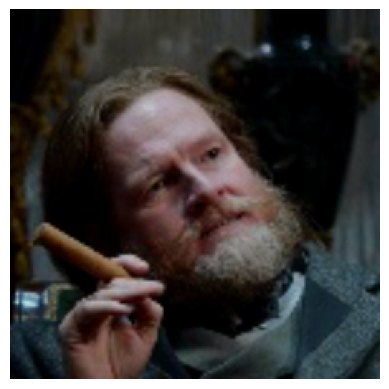

real age  tensor(46.)
Predicted Age: 34.75543975830078


In [34]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

def show_image(tensor_image, means, stds):
    numpy_image = tensor_image.cpu().numpy()

    # unormalization
    numpy_image = np.transpose(numpy_image, (1, 2, 0))
    numpy_image = numpy_image * stds + means
    numpy_image = np.clip(numpy_image, 0, 1)

    # show
    plt.imshow(numpy_image)
    plt.axis('off')
    plt.show()


with torch.no_grad():
    #TAKES AN IMAGE FROM THE DATASET, BUT ANY IMAGE CAN BE INPUTED
    image_tensor = data_train_loader.dataset[2][0]
    show_image(image_tensor, pretrained_means, pretrained_stds)

    age_real = data_train_loader.dataset[2][1]
    print("real age ", age_real)
    image_tensor = image_tensor.unsqueeze(0).to(device)
    age_pred, _ = model(image_tensor)  # do forward pass
    predicted_age = age_pred.item()
print("Predicted Age:", predicted_age)


###Pixels net

In [35]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [36]:
def plot_filtered_images(images, filters, n_filters=None, normalize=True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1, 2, 0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

    fig.subplots_adjust(hspace=-0.7)

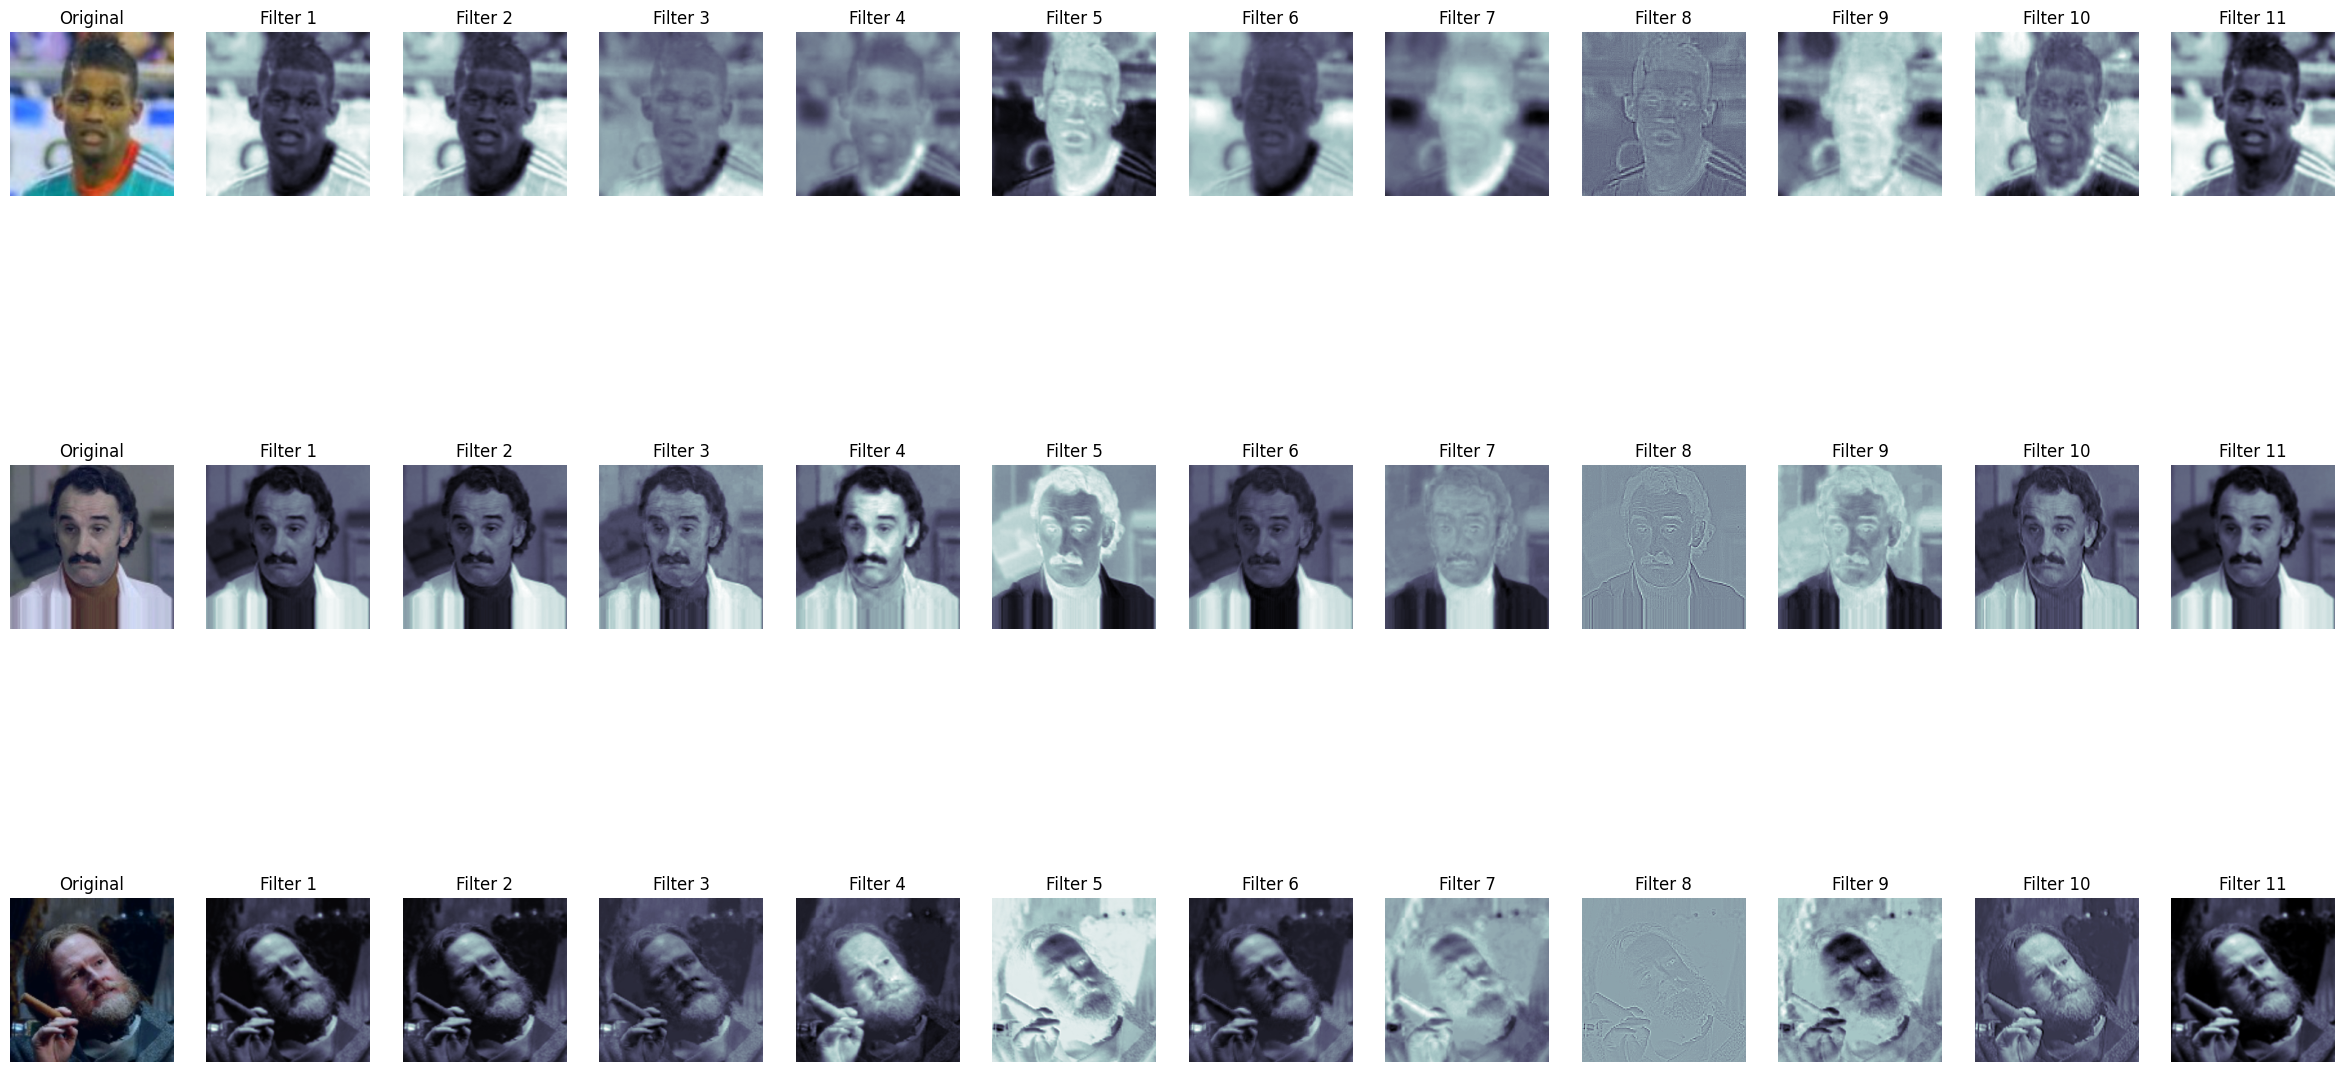

In [39]:
N_IMAGES = 3
N_FILTERS = 11

images = [image for image in [data_train_loader.dataset[i][0] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)


###CHECK DATA DISTRIBUTION

In [ ]:

#extract all the ages
import numpy as np
from tqdm import tqdm

ages = []

progress_bar = tqdm(total=len(data_train_loader.dataset), desc="Extracting Ages")

for batch in data_train_loader:
    _, targets,_,_ = batch
    ages.extend(targets.cpu().numpy())
    progress_bar.update(1)

ages = np.array(ages)

progress_bar.close()


Extracting Ages:   1%|          | 67/6686 [00:00<00:10, 603.21it/s]


In [ ]:
len(ages)

6686

Minimum Age: 20.0
Maximum Age: 50.0
Mean Age: 34.71328
Median Age: 35.0
Standard Deviation of Age: 8.869491


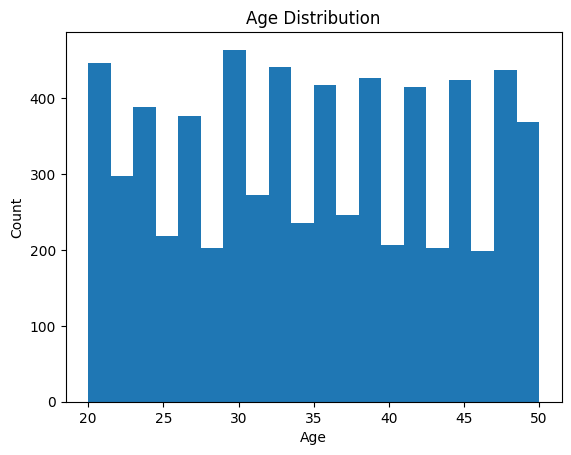

In [ ]:
import matplotlib.pyplot as plt

# Compute descriptive statistics
min_age = np.min(ages)
max_age = np.max(ages)
mean_age = np.mean(ages)
median_age = np.median(ages)
std_age = np.std(ages)

print("Minimum Age:", min_age)
print("Maximum Age:", max_age)
print("Mean Age:", mean_age)
print("Median Age:", median_age)
print("Standard Deviation of Age:", std_age)

# Visualize the distribution
plt.hist(ages, bins=20)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution")
plt.show()
